# Introduction
This notebook describes all the simulations presented in the report _"On Composite NUV Priors and Hierarchical Models"_. This includes code to replicate the used data as well as the presented estimations, while also pointing out some additional interesting aspects. The structure of this notebook corresponds to the structure of the report, i.e., they are meant to be worked thorugh in parallel. Generally, everything that somehow can be tuned or adapted is marked by a comment _TODO: 'what to do'_ statement. Note that all the all the importet models can be found __[here](https://github.com/lubischu/nuvPriors)__ .

In [1]:
# This cell sets up the environment. It has to be exectued every time the kernel is restarted to make sure the 
# subsequent cells run properly!

# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt

# Add path of nuvPriors repository
#sys.path.append('path_to_repo')   # TODO: Change 'path_to_repo' to actual path of repository.

# Import investigated models
from compositeNUVs.models.pwcModel import PWCModel
from compositeNUVs.models.modelSelector import ModelSelector
from compositeNUVs.models.clfModel import CLFModel
from compositeNUVs.models.rtbModel import RTBModel
from compositeNUVs.models.covModel import CovModel
from compositeNUVs.models.hiModel import HiModel

# Chapter 3: Model Selector

## Trivial Example: Fitting Known Levels
The following cell generates scalar PWC data that has been used for multiple simulations in the report (trivial example, CLF and RTB model). Subsequently, the model selector mechanism is used to fit a PWC line to this data, where the estimator knows the exact underlying levels. The corresponding estimates are then plotted along with with a plot visualizing the evolution of the model selector vector S_i.

Text(0.5, 0.98, 'Generated Observations')

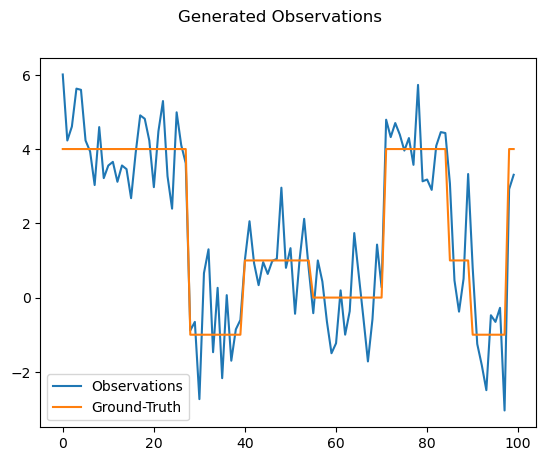

In [2]:
# Specify parameters
N = 100
M = 4
D = 1
varNoise = 1.0   # TODO: Vary the noise power and observe its effect.
seed = 0   # TODO: Change seed to generate fresch data (for report, seed=0 has been used).
np.random.seed(seed)

# Specify levels and array with level indices
levels = np.array([[-1.0], [0.0], [1.0], [4.0]])
selectedLevels = np.zeros(N, dtype=int)
ind_start = 0
while ind_start < N:
    ind_stop = ind_start + np.random.randint(low=int(N/20), high=int(N/10))
    selectedLevels[ind_start:ind_stop] = np.random.randint(low=0, high=M)
    ind_start = ind_stop
    
# Calculate X and Y
x_cl = np.array([levels[selectedLevel_i] for selectedLevel_i in selectedLevels])
y_cl = np.random.normal(x_cl,varNoise)

# Plot data
fig_cl, axs_cl = plt.subplots()
axs_cl.plot(y_cl, label='Observations')
axs_cl.plot(x_cl, label='Ground-Truth')
axs_cl.legend()
fig_cl.suptitle('Generated Observations')

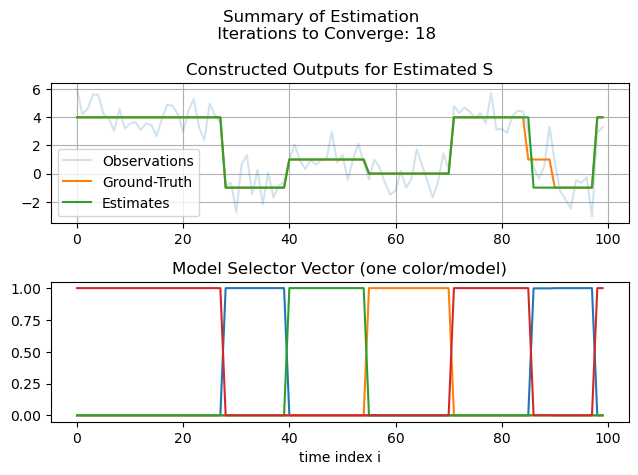

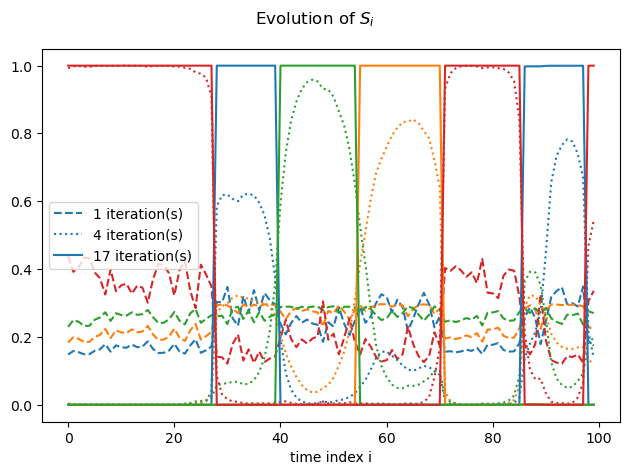

In [3]:
# Construct known sigmas and model outputs
sigmas = np.tile(np.identity(D, dtype=float), (M,1,1))
x_perModel = np.tile(levels, (N,1,1))

priorType_oneHot='repulsive_logCost'   # TODO: Change the used method to enhance all-{0,1} solutions in the One-Hot 
    # prior. Possible chices are ['sparse', 'repulsive_logCost', 'repulsive_laplace', 'discrete']
diff_convTh = 1e-4   # Default is 1e-2, makes sure to get a smooth plot.

########################################################################################################################

# Initialize estimator
modelSelector = ModelSelector(N=N, M=M, sigmas=sigmas)

# Create figures
fig_triv, axs_triv = plt.subplots(2,1)
fig_evol, axs_evol = plt.subplots()

# Perform estimations and plot evolution of S_i
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
styles = ['dashed', 'dotted', 'solid']
i_it = 0
# Iterate for different n_it_irls
for i, n_it_irls_max_i in enumerate([1, 3, 100]):
    
    # Do estimation
    diffAZOSol, i_it_new, conv_time = modelSelector.estimate_selectedModel(
        y=y_cl, x_perModel=x_perModel, n_it_irls=n_it_irls_max_i, priorType_oneHot=priorType_oneHot, diff_convTh=diff_convTh, 
        disable_progressBar=True)
    i_it += i_it_new + 1
    
    # Plot ms_hat
    ms_hat,_ = modelSelector.get_sHat()
    for m in range(M):
        if m==0:
            axs_evol.plot(ms_hat[:,m], c=colors[m], linestyle=styles[i], label=f'{i_it} iteration(s)')
        else:
            axs_evol.plot(ms_hat[:,m], c=colors[m], linestyle=styles[i])

axs_evol.legend()
axs_evol.set_xlabel('time index i')

fig_evol.suptitle('Evolution of $S_i$')
fig_evol.tight_layout()
        
# Construct final x_hat estimate
selectedModel = np.argmax(ms_hat, axis=1)
x_cl_hat = np.array([levels[selectedModel_i] for selectedModel_i in selectedModel])

# Plot summary of final estimation
axs_triv[0].plot(y_cl[:,0], alpha=0.2, label='Observations')
axs_triv[0].plot(x_cl[:,0], label='Ground-Truth')
axs_triv[0].plot(x_cl_hat[:,0], label='Estimates')
axs_triv[0].legend()
axs_triv[0].grid()
axs_triv[0].set_title('Constructed Outputs for Estimated S')

axs_triv[1].plot(ms_hat)
axs_triv[1].set_xlabel('time index i')
axs_triv[1].set_title('Model Selector Vector (one color/model)')

fig_triv.suptitle(f'Summary of Estimation \n Iterations to Converge: {i_it + 1}')
fig_triv.tight_layout()

## Fitting Finite Number of Constant Levels
For this simulation the previously generated observations are reused. For the estimation, the levels are no longer given but are now estimated too. Note that for each time the simulation is re-run, the estimates change slightly. This is because the final estimate depends on the random initialization of the initial guess of the levels, which is different each time the cell is re-run. 

  3%|██████▍                                                                                                                                                                                                                               | 28/1000 [00:00<00:06, 154.39it/s]


(1000, 4, 1)


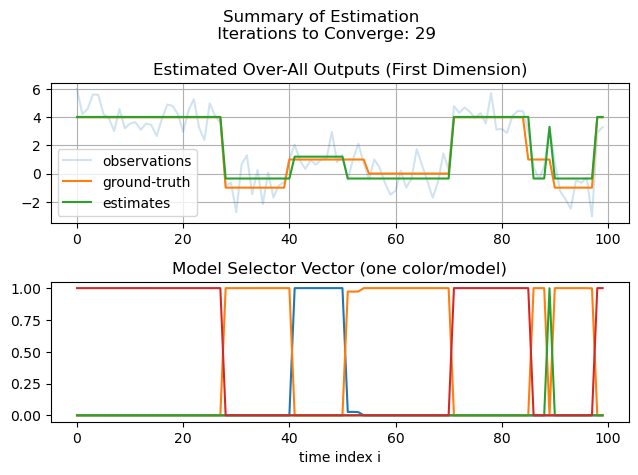

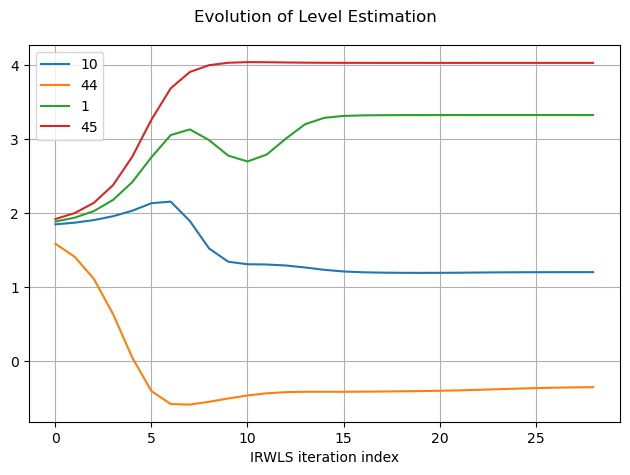

In [4]:
M_init = M   # Assumed number of underlying models.

# Initialize estimator
estimator = CLFModel(N=N, M=M_init, D=D)

# Do estimation
performanceMetrics, ml_hat_evol, i_it, conv_time = estimator.estimate_output(y=y_cl)

########################################################################################################################

# Get estimates
outputs = estimator.get_output()
ms_hat,_ = estimator.modelSelector.get_sHat()

# Plot estimations
fig_clfEst, axs_clfEst = plt.subplots(2,1)

axs_clfEst[0].plot(y_cl[:,0], alpha=0.2, label='observations')
axs_clfEst[0].plot(x_cl[:,0], label='ground-truth')
axs_clfEst[0].plot(outputs[:,0], label='estimates')
axs_clfEst[0].legend()
axs_clfEst[0].grid()
axs_clfEst[0].set_title('Estimated Over-All Outputs (First Dimension)')

axs_clfEst[1].plot(ms_hat)
axs_clfEst[1].set_xlabel('time index i')
axs_clfEst[1].set_title('Model Selector Vector (one color/model)')

fig_clfEst.suptitle(f'Summary of Estimation \n Iterations to Converge: {i_it + 1}')
fig_clfEst.tight_layout()

########################################################################################################################

# Plot evolution of level estimates
fig_clfEvol, axs_clfEvol = plt.subplots()

sMaxInd = np.argmax(ms_hat, axis=1)
countModels = np.array([np.count_nonzero(sMaxInd == m) for m in range(M_init)])
print(ml_hat_evol.shape)

for m, level_m_evol in enumerate(np.transpose(ml_hat_evol, (1,0,2))):
    if countModels[m] > 0:
        axs_clfEvol.plot(level_m_evol[:i_it+1,0], label=f'{countModels[m]}')
    else:
        axs_clfEvol.plot(level_m_evol[:i_it+1,0], alpha=0.3)
axs_clfEvol.legend()
axs_clfEvol.set_xlabel('IRWLS iteration index')
axs_clfEvol.grid()

fig_clfEvol.suptitle('Evolution of Level Estimation')
fig_clfEvol.tight_layout()

## PWC Model With Base Level
The simulation for this model requires us to generate new data, matching the assumed behaviour of it. This is done in the following cell. Afterwards, the corresponding estimates are computed.

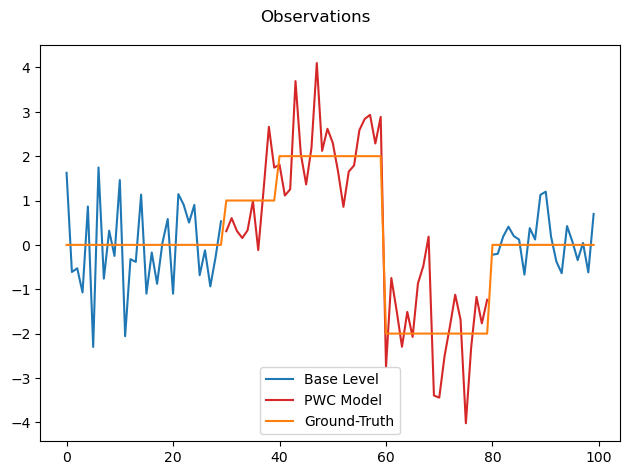

In [5]:
# Specify Parameters
N = 100
M = 2
D = 1
varNoise = 1.0   # TODO: Vary noise power.
seed = 1
np.random.seed(seed)

covNoise = np.tile(np.identity(D, dtype=float)*varNoise, (N,1,1))

# Specify model indices
selectedModel = np.concatenate(
    (np.zeros(int(0.3*N), dtype=int), 
     np.ones(int(0.5*N), dtype=int), 
     np.zeros(int(0.2*N), dtype=int)), 
    axis=0)

# Specify levels
levels_pwc = [1.0, 2.0, -2.0]   # TODO: Vary levels of PWC data.

x_m0 = np.zeros((N,D), dtype=float)
x_m1 = np.concatenate(
    (np.ones((int(0.4*N),D), dtype=int)*levels_pwc[0], 
     np.ones((int(0.2*N),D), dtype=int)*levels_pwc[1], 
     np.ones((int(0.4*N),D), dtype=int)*levels_pwc[2]), 
    axis=0)
x_allModels = np.concatenate((x_m0[:,np.newaxis,:], x_m1[:,np.newaxis,:]), axis=1)

# Calculate X and Y
x_rtb = np.array([x_allModels[i,selectedModel_i] for i, selectedModel_i in zip (range(N), selectedModel)])
y_rtb = np.array([np.random.multivariate_normal(x_i, covNoise_i) for x_i, covNoise_i in zip(x_rtb, covNoise)])

# Plot data
fig_rtb, axs_rtb = plt.subplots()

y_m0 = np.where(selectedModel[:,np.newaxis]==0, y_rtb, np.nan)
y_m1 = np.where(selectedModel[:,np.newaxis]==1, y_rtb, np.nan)

axs_rtb.plot(y_m0, label='Base Level', c='tab:blue')
axs_rtb.plot(y_m1, label='PWC Model', c='tab:red')
axs_rtb.plot(x_rtb, label='Ground-Truth', c='tab:orange')
axs_rtb.legend(loc='lower center')

fig_rtb.suptitle('Observations')
fig_rtb.tight_layout()

  3%|██████▋                                                                                                                                                                                                                                | 29/1000 [00:00<00:25, 38.65it/s]


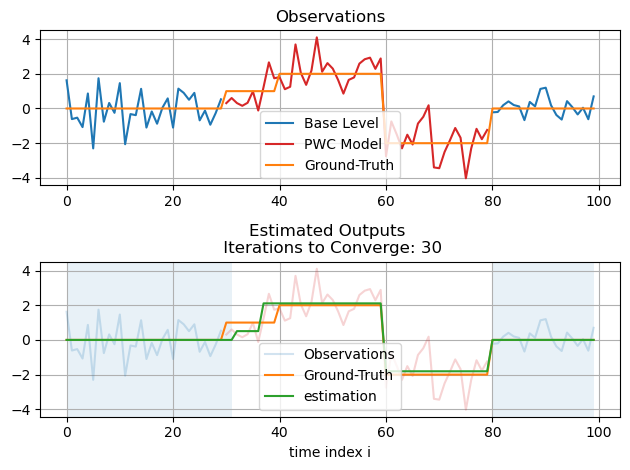

In [6]:
# Construct sigmas (i.e., assumed observation noise per model) and known base level
sigmas = np.array([np.identity(D, dtype=float)*2.0, np.identity(D, dtype=float)*1.0])   # alpha=2.0
constLevel = np.zeros((1,1), dtype=float)

beta_u_x = 1.5   # TODO: Vary sparsifying tuning parameter of model selector (for report, beta_u_x=1.5 has been used)

########################################################################################################################

# Initialize estimator
estimator = RTBModel(N=N, D=D, constLevel=constLevel, sigmas=sigmas)

# Do estimation
performanceMetrics, i_it_outer, conv_time = estimator.estimate_output(y=y_rtb, beta_u_x=beta_u_x)

########################################################################################################################

# Get estimates
ms_hat, _ = estimator.get_sHat()
selectedModel = np.argmax(ms_hat, axis=1)
mx_hat, _ = estimator.get_xHat()
output = estimator.get_output()

# Plot estimations
fig2, axs2 = plt.subplots(2,1)

axs2[0].plot(y_m0, label='Base Level', c='tab:blue')
axs2[0].plot(y_m1, label='PWC Model', c='tab:red')
axs2[0].plot(x_rtb, label='Ground-Truth', c='tab:orange')
axs2[0].legend(loc='lower center')
axs2[0].grid()
axs2[0].set_title('Observations')

axs2[1].plot(y_m0, alpha=0.2, label='Observations', c='tab:blue')
axs2[1].plot(y_m1, alpha=0.2, c='tab:red')
axs2[1].plot(x_rtb, label='Ground-Truth', c='tab:orange')
axs2[1].plot(output, label='estimation', c='tab:green')
axs2[1].fill_between(np.where(selectedModel==0, np.arange(N), np.nan), np.ones(N)*-1e3, np.ones(N)*1e3, alpha=0.1)
axs2[1].set_ylim(axs2[0].get_ylim())
axs2[1].set_xlabel('time index i')
axs2[1].legend(loc='lower center')
axs2[1].set_title(f'Estimated Outputs \n Iterations to Converge: {i_it_outer + 1}')
axs2[1].grid()

fig2.tight_layout()

## Further Important Aspects and Their Applications

### Distinguishing Between Different Correlation Patterns
For this simulation, the following cell generated 2-D data which is effectively zero-mean Gaussian noise where the two dimensions either correlate positively or negatively. The following cell then does the estimation.

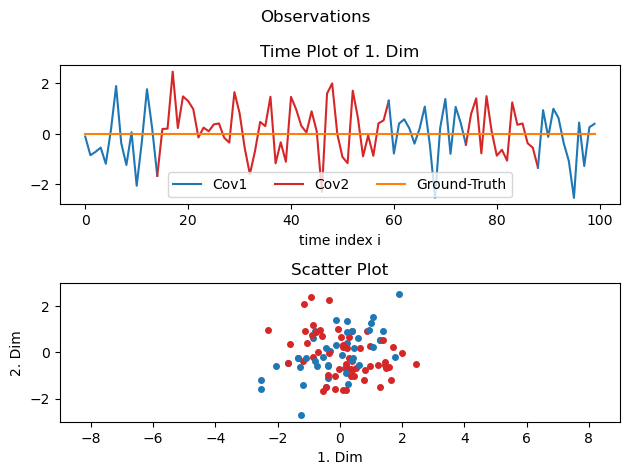

In [7]:
# Specify parameters
N = 100
M = 2
D = 2
corr = 0.5   # TODO: Vary corr, which specifies the amount of correlation between the two dimensions.
seed = 0   # TODO: Vary seed to generate different patterns.
np.random.seed(seed)

# Specify covs and array with cov indices
covs = np.array([[[1.0, corr], [corr, 1.0]], [[1.0, -corr], [-corr, 1.0]]])
selectedCovs = np.zeros(N, dtype=int)
ind_start = 0
while ind_start < N:
    ind_stop = ind_start + np.random.randint(low=int(N/10), high=int(N/5))
    selectedCovs[ind_start:ind_stop] = np.random.randint(low=0, high=M)
    ind_start = ind_stop
    
# Calculate X and Y
x_dS = np.zeros((N,D), dtype=float)
sigma = np.array([covs[selectedCovs_i] for selectedCovs_i in selectedCovs])
y_dS = np.array(
    [np.random.multivariate_normal(np.zeros(D, dtype=float), covs[selectedCovs_i]) for selectedCovs_i in selectedCovs])

# Plot data
modelChange_ind = []
for i in range(1,N):
    if selectedCovs[i-1] != selectedCovs[i]:
        modelChange_ind.append(i)
modelChange_ind.append(N)

fig_dS, axs_dS = plt.subplots(2,1)

start_ind = 0
colors = ['tab:blue', 'tab:red', 'tab:olive', 'tab:grey']
seen_covs = []
for end_ind in modelChange_ind:
    if selectedCovs[end_ind-1] in seen_covs:
        axs_dS[0].plot(
            np.arange(start_ind, end_ind), y_dS[start_ind:end_ind, 0], c=colors[selectedCovs[end_ind-1]])
        axs_dS[1].scatter(
            y_dS[start_ind:end_ind,0], y_dS[start_ind:end_ind,1], s=16, 
            c=colors[selectedCovs[end_ind-1]])
    else:
        axs_dS[0].plot(
            np.arange(start_ind, end_ind), y_dS[start_ind:end_ind, 0], c=colors[selectedCovs[end_ind-1]], 
            label=f'Cov{len(seen_covs)+1}')
        axs_dS[1].scatter(
            y_dS[start_ind:end_ind,0], y_dS[start_ind:end_ind,1], s=16, 
            c=colors[selectedCovs[end_ind-1]])
        seen_covs.append(selectedCovs[end_ind-1])
    start_ind = end_ind-1
axs_dS[0].plot(x_dS[:,0], c='tab:orange', label='Ground-Truth')
axs_dS[0].set_xlabel('time index i')
axs_dS[0].set_title('Time Plot of 1. Dim')
axs_dS[0].legend(ncol=4, loc='lower center')

axs_dS[1].set_xlabel('1. Dim')
axs_dS[1].set_ylabel('2. Dim')
axs_dS[1].set_xlim([-9, 9])
axs_dS[1].set_ylim([-3, 3])
axs_dS[1].set_title('Scatter Plot')

fig_dS.suptitle('Observations')
fig_dS.tight_layout()

 13%|██████████████████████████████                                                                                                                                                                                                         | 13/100 [00:00<00:00, 138.64it/s]


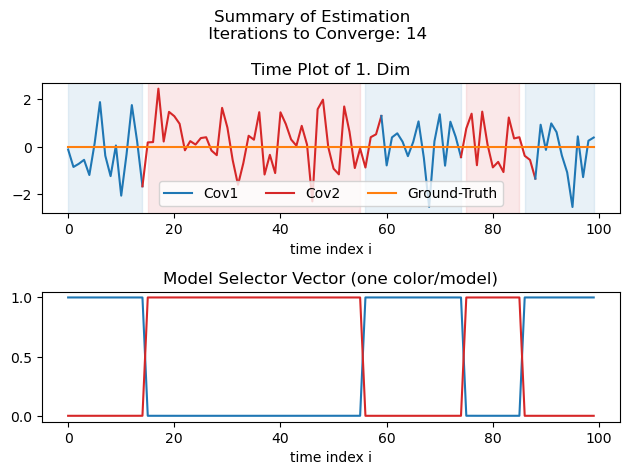

In [8]:
# Construct known sigmas and model outputs
x_perModel = np.tile(x_dS[:,np.newaxis,:], (1,M,1))

# Initialize estimator
modelSelector = ModelSelector(N=N, M=M, sigmas=covs)

# Do estimation
diffAZOSol, i_it, conv_time = modelSelector.estimate_selectedModel(
    y=y_dS, x_perModel=x_perModel, diff_convTh=1e-4)

########################################################################################################################

# Get S and construct X_hat
ms_hat,_ = modelSelector.get_sHat()
selectedModel = np.argmax(ms_hat, axis=1)

maxObs = np.max(np.abs(y_dS))

# Plot estimations
fig_dSEst, axs_dSEst = plt.subplots(2,1)

colors = ['tab:blue', 'tab:red', 'tab:olive', 'tab:grey']
seen_covs = []
start_ind = 0
for end_ind in modelChange_ind:
    if selectedCovs[end_ind-1] in seen_covs:
        axs_dSEst[0].plot(
            np.arange(start_ind, end_ind), y_dS[start_ind:end_ind, 0], c=colors[selectedCovs[end_ind-1]])
    else:
        axs_dSEst[0].plot(
            np.arange(start_ind, end_ind), y_dS[start_ind:end_ind, 0], c=colors[selectedCovs[end_ind-1]], 
            label=f'Cov{len(seen_covs)+1}')
        seen_covs.append(selectedCovs[end_ind-1])
    start_ind = end_ind-1
axs_dSEst[0].fill_between(
    np.where(selectedModel==0, np.arange(N), np.nan), np.ones(N)*-1e3, np.ones(N)*1e3, color='tab:blue', alpha=0.1)
axs_dSEst[0].fill_between(
    np.where(selectedModel==1, np.arange(N), np.nan), np.ones(N)*-1e3, np.ones(N)*1e3, color='tab:red', alpha=0.1)
axs_dSEst[0].set_ylim(axs_dS[0].get_ylim())
axs_dSEst[0].plot(x_dS[:,0], c='tab:orange', label='Ground-Truth')
axs_dSEst[0].set_xlabel('time index i')
axs_dSEst[0].set_title('Time Plot of 1. Dim')
axs_dSEst[0].legend(ncol=4, loc='lower center')

axs_dSEst[1].plot(ms_hat[:,0], c='tab:blue')
axs_dSEst[1].plot(ms_hat[:,1], c='tab:red')
axs_dSEst[1].set_xlabel('time index i')
axs_dSEst[1].set_title('Model Selector Vector (one color/model)')

fig_dSEst.suptitle(f'Summary of Estimation \n Iterations to Converge: {i_it + 1}')
fig_dSEst.tight_layout()

### Discarding Unused Models
Comming back to the case of the CLF model, but without knowing the exact number of underlying models. The following simulation is again based on the PWC scalar data, initially generated for the trivial example. The following cell perfoms the estimation, after which both a summary of the final estimates as well as visulaization of the evolving level estimates is plotted. Again, it is note here that the finial estimates slightly change each time the simulation is re-run, as the inital guesses about the levels are randomly initialized.

  6%|████████████▋                                                                                                                                                                                                                         | 55/1000 [00:00<00:08, 110.05it/s]


(1000, 20, 1)


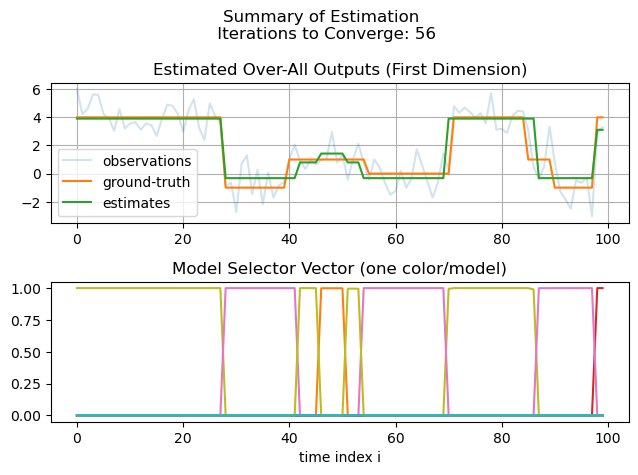

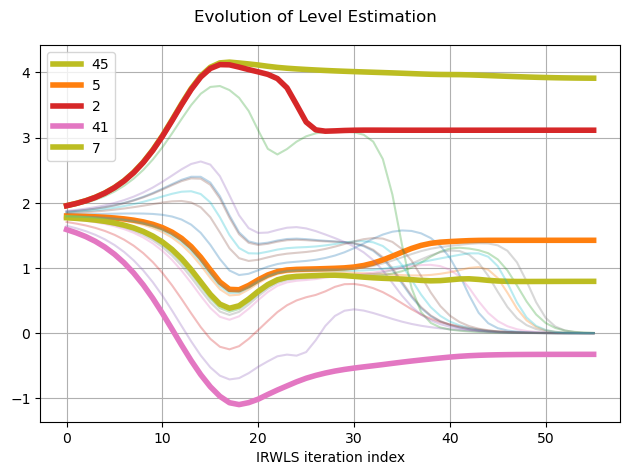

In [9]:
# Specify how many levels should be assumed. Here, the correct amount (i.e., M) is given.
M_init = 20   # TODO: Vary the initially assumed number of models (for report, M_init=20 was chosen)
beta_u_s = 3.0   # TODO: Vary sparsifying parameter of model selector (for report, beta_u_s=3.0 was chosen)

########################################################################################################################

# Initialize estimator
D = 1
estimator = CLFModel(N=N, M=M_init, D=D)

# Do estimation with 'levelEstType' = 'superPos' (this is the default configuration)
performanceMetrics, ml_hat_evol, i_it, conv_time = estimator.estimate_output(y=y_cl, beta_u_s=beta_u_s)

########################################################################################################################

# Get estimates
outputs = estimator.get_output()
ms_hat,_ = estimator.modelSelector.get_sHat()

# Plot estimations
fig_clfLMEst, axs_clfLMEst = plt.subplots(2,1)

axs_clfLMEst[0].plot(y_cl[:,0], alpha=0.2, label='observations')
axs_clfLMEst[0].plot(x_cl[:,0], label='ground-truth')
axs_clfLMEst[0].plot(outputs[:,0], label='estimates')
axs_clfLMEst[0].legend()
axs_clfLMEst[0].grid()
axs_clfLMEst[0].set_title('Estimated Over-All Outputs (First Dimension)')

axs_clfLMEst[1].plot(ms_hat)
axs_clfLMEst[1].set_xlabel('time index i')
axs_clfLMEst[1].set_title('Model Selector Vector (one color/model)')

fig_clfLMEst.suptitle(f'Summary of Estimation \n Iterations to Converge: {i_it + 1}')
fig_clfLMEst.tight_layout()

########################################################################################################################

# Plot evolution of level estimates
fig_clfLMEvol, axs_clfLMEvol = plt.subplots()

sMaxInd = np.argmax(ms_hat, axis=1)
countModels = np.array([np.count_nonzero(sMaxInd == m) for m in range(M_init)])
print(ml_hat_evol.shape)

for m, level_m_evol in enumerate(np.transpose(ml_hat_evol, (1,0,2))):
    if countModels[m] > 0:
        axs_clfLMEvol.plot(level_m_evol[:i_it+1,0], label=f'{countModels[m]}', linewidth=4)
    else:
        axs_clfLMEvol.plot(level_m_evol[:i_it+1,0], alpha=0.3)
axs_clfLMEvol.legend()
axs_clfLMEvol.set_xlabel('IRWLS iteration index')
axs_clfLMEvol.grid()

fig_clfLMEvol.suptitle('Evolution of Level Estimation')
fig_clfLMEvol.tight_layout()

# Covariance Estimation

## Estimating PWC Covariance Matrices of Zero-Mean Gaussian Noise
The following cell generates zero-mean Gaussian noise in D=3 dimensions. Thereby, the underlying noise covariance matrices are PWC. In the subsequent cell, the covariance estimation method is used to estimate these underlying PWC covariance matrices base on the generated data.

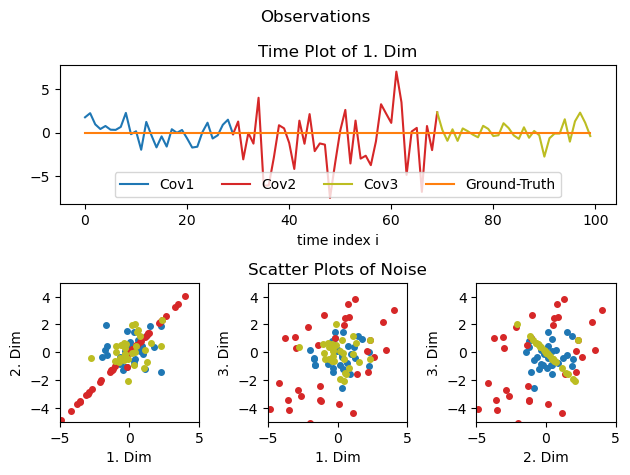

In [10]:
# Specify Parameters
N = 100
D = 3
seed = 0
np.random.seed(seed)

# Specify model indices
selectedModel = np.concatenate(
    (np.zeros(int(0.3*N), dtype=int), 
     np.ones(int(0.4*N), dtype=int), 
     np.ones(int(0.3*N), dtype=int)*2), 
    axis=0)

# Specify noise covariance matrices
mean = np.array([0.0, 0.0, 0.0])
covNoises = np.tile(np.identity(D, dtype=float), (3,1,1))
covNoises[1,0,1] = 1.0
covNoises[1,1,0] = 1.0
covNoises[2,1,2] = -1.0
covNoises[2,2,1] = -1.0
covNoises[1] *= 10.0

# Calculate X and Y
x_cov = np.tile(mean, (N,1))
sigma = np.array([covNoises[selectedModel_i] for selectedModel_i in selectedModel])
y_cov = np.array([np.random.multivariate_normal(mean, covNoises[selectedModel_i]) for selectedModel_i in selectedModel])
   
# Plot data 
modelChange_ind = []
for i in range(1,N):
    if selectedModel[i-1] != selectedModel[i]:
        modelChange_ind.append(i)
modelChange_ind.append(N)

fig_cov, axs_cov = plt.subplots(2,3)
gs = axs_cov[0,0].get_gridspec()
for ax in axs_cov[0,:]:
    ax.remove()
axbig = fig_cov.add_subplot(gs[0,:])

start_ind = 0
colors = ['tab:blue', 'tab:red', 'tab:olive']
for color, end_ind in enumerate(modelChange_ind):
    axbig.plot(np.arange(start_ind, end_ind), y_cov[start_ind:end_ind, 0], c=colors[color])
    axs_cov[1,0].scatter(y_cov[start_ind:end_ind,0], y_cov[start_ind:end_ind,1], s=16, c=colors[color])
    axs_cov[1,1].scatter(y_cov[start_ind:end_ind,0], y_cov[start_ind:end_ind,2], s=16, c=colors[color])
    axs_cov[1,2].scatter(y_cov[start_ind:end_ind,1], y_cov[start_ind:end_ind,2], s=16, c=colors[color])
    start_ind = end_ind-1
axbig.plot(x_cov[:,0], c='tab:orange')
axbig.set_xlabel('time index i')
axbig.set_title('Time Plot of 1. Dim')
axbig.legend(['Cov1', 'Cov2', 'Cov3', 'Ground-Truth'], ncol=4, loc='lower center')

for ax in axs_cov[1,:]:
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
axs_cov[1,0].set_xlabel('1. Dim')
axs_cov[1,0].set_ylabel('2. Dim')
axs_cov[1,1].set_xlabel('1. Dim')
axs_cov[1,1].set_ylabel('3. Dim')
axs_cov[1,2].set_xlabel('2. Dim')
axs_cov[1,2].set_ylabel('3. Dim')
axs_cov[1,1].set_title('Scatter Plots of Noise')

fig_cov.suptitle('Observations')
fig_cov.tight_layout()

  0%|                                                                                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]/Users/haguettaz/Downloads/compositeNUVs/src/cnuv/models/pwcModel.py:400: RuntimeWarning: divide by zero encountered in divide
  np.abs(mx_hat_new - self.mx_hat) / np.abs(self.mx_hat))
/Users/haguettaz/Downloads/compositeNUVs/src/cnuv/models/covModel.py:134: RuntimeWarning: divide by zero encountered in divide
  np.abs(mj_hat - mj_hat_new) / np.abs(mj_hat))
  3%|███████▌                                                                                                                                                                                                                              | 33/1000 [00:00<00:04, 199.38it/s]


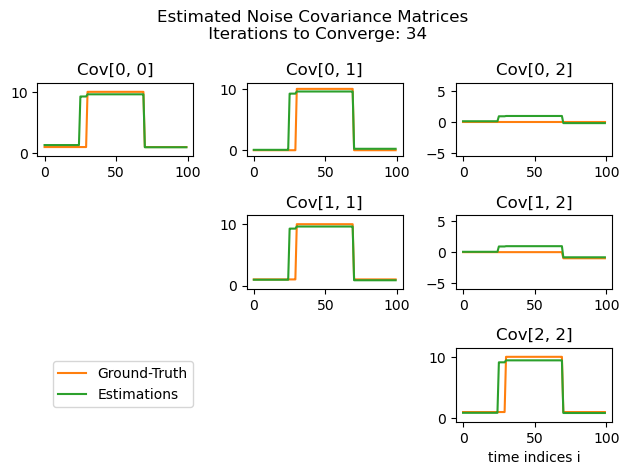

In [11]:
beta_u = 10.0   # TODO: Vary sparsifying tuning parameter of underlying PWC model (in report, beta_u=10.0 was chosen)

########################################################################################################################

# Initialize estimator
estimator = CovModel(N=N, D=D)

# Do estimation
changes, i_it, conv_time = estimator.estimate_VICF(z_hat=y_cov-x_cov, beta_u=beta_u, met_convTh=1e-2)

########################################################################################################################

# Plot estimations
noiseCov_hat = estimator.calculate_noiseCov()

fig_covEst, axs_covEst = plt.subplots(3,3, squeeze=False)

# Delete subplots that are not in upper-triangular
for i in range(3):
    for j in range(i):
        axs_covEst[i,j].remove()
        
# Calculate window width
min_ij = np.minimum(np.min(noiseCov_hat, axis=0), np.min(sigma, axis=0))
max_ij = np.maximum(np.max(noiseCov_hat, axis=0), np.max(sigma, axis=0))
avg_ij = (max_ij - min_ij) / 2 + min_ij
maxDiff_scaled = np.max(max_ij - min_ij)*1.2

# Iterate through remaining axes
for i in range(3):
    for j in range(i,3):
        axs_covEst[i,j].plot(sigma[:,i,j], c='tab:orange')
        axs_covEst[i,j].plot(noiseCov_hat[:,i,j], c='tab:green')
        axs_covEst[i,j].set_title(f'Cov[{i}, {j}]')
        
        avg = avg_ij[i,j]
        axs_covEst[i,j].set_ylim(avg - maxDiff_scaled/2, avg + maxDiff_scaled/2)

axs_covEst[2,2].set_xlabel('time indices i')
        
fig_covEst.suptitle(f'Estimated Noise Covariance Matrices \n Iterations to Converge: {i_it + 1}')
fig_covEst.legend(['Ground-Truth', 'Estimations'], loc='center', bbox_to_anchor=(0.2, 0.2))
fig_covEst.tight_layout()

## Hierarchical Model
For the simulation of the hierarchical model, the same covariance pattern is used again. For simplicity, the previously generated data is simply added to some PWC mean in the following cell, generating the given observations for this last simulation. The actual estimation is performed in the subsequent cell. Note that for this estimator to work, two sparsifying parameters (those of the mean and covariance model) have to be tuned!

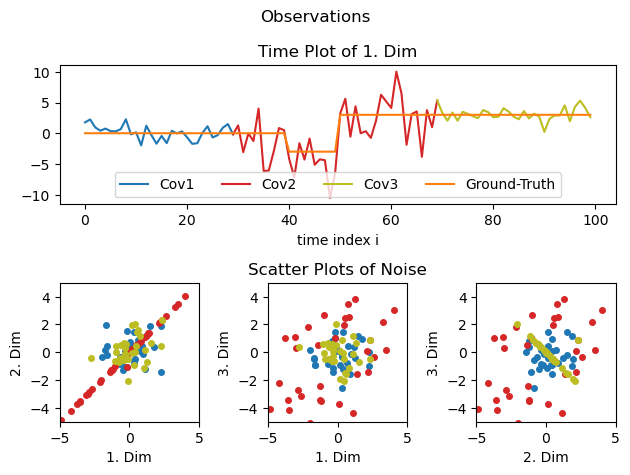

In [12]:
# Specifying means and their indices
means = np.array([[0.0, 0.0, 0.0], [-3.0, -3.0, -3.0], [3.0, 3.0, 3.0]])

selectedModel_mean = np.concatenate(
    (np.zeros(int(0.4*N), dtype=int), 
     np.ones(int(0.1*N), dtype=int), 
     np.ones(int(0.5*N), dtype=int)*2), 
    axis=0)

# Generate X and Y
x_hi = np.array([means[selectedModel_mean_i] for selectedModel_mean_i in selectedModel_mean])
y_hi = x_hi + y_cov
sigmas = np.array([covNoises[selectedModel_cov_i] for selectedModel_cov_i in selectedModel])
   
# Plot data 
fig_hi, axs_hi = plt.subplots(2,3)

gs = axs_hi[0,0].get_gridspec()
for ax in axs_hi[0,:]:
    ax.remove()
axbig = fig_hi.add_subplot(gs[0,:])

start_ind = 0
colors = ['tab:blue', 'tab:red', 'tab:olive']
for color, end_ind in enumerate(modelChange_ind):
    axbig.plot(np.arange(start_ind, end_ind), y_hi[start_ind:end_ind, 0], c=colors[color])
    axs_hi[1,0].scatter(
        y_hi[start_ind:end_ind,0]-x_hi[start_ind:end_ind,0], 
        y_hi[start_ind:end_ind,1]-x_hi[start_ind:end_ind,1], 
        s=16, c=colors[color])
    axs_hi[1,1].scatter(
        y_hi[start_ind:end_ind,0]-x_hi[start_ind:end_ind,0], 
        y_hi[start_ind:end_ind,2]-x_hi[start_ind:end_ind,2], 
        s=16, c=colors[color])
    axs_hi[1,2].scatter(
        y_hi[start_ind:end_ind,1]-x_hi[start_ind:end_ind,1], 
        y_hi[start_ind:end_ind,2]-x_hi[start_ind:end_ind,2], 
        s=16, c=colors[color])
    start_ind = end_ind-1
axbig.plot(x_hi[:,0], c='tab:orange')
axbig.set_xlabel('time index i')
axbig.set_title('Time Plot of 1. Dim')
axbig.legend(['Cov1', 'Cov2', 'Cov3', 'Ground-Truth'], ncol=4, loc='lower center')

for ax in axs_hi[1,:]:
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
axs_hi[1,0].set_xlabel('1. Dim')
axs_hi[1,0].set_ylabel('2. Dim')
axs_hi[1,1].set_xlabel('1. Dim')
axs_hi[1,1].set_ylabel('3. Dim')
axs_hi[1,2].set_xlabel('2. Dim')
axs_hi[1,2].set_ylabel('3. Dim')
axs_hi[1,1].set_title('Scatter Plots of Noise')

fig_hi.suptitle('Observations')
fig_hi.tight_layout()

  0%|                                                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]/Users/haguettaz/Downloads/compositeNUVs/src/cnuv/models/pwcModel.py:400: RuntimeWarning: divide by zero encountered in divide
  np.abs(mx_hat_new - self.mx_hat) / np.abs(self.mx_hat))
/Users/haguettaz/Downloads/compositeNUVs/src/cnuv/models/covModel.py:134: RuntimeWarning: divide by zero encountered in divide
  np.abs(mj_hat - mj_hat_new) / np.abs(mj_hat))
  2%|████▌                                                                                                                                                                                                                                 | 20/1000 [00:00<00:03, 259.54it/s]


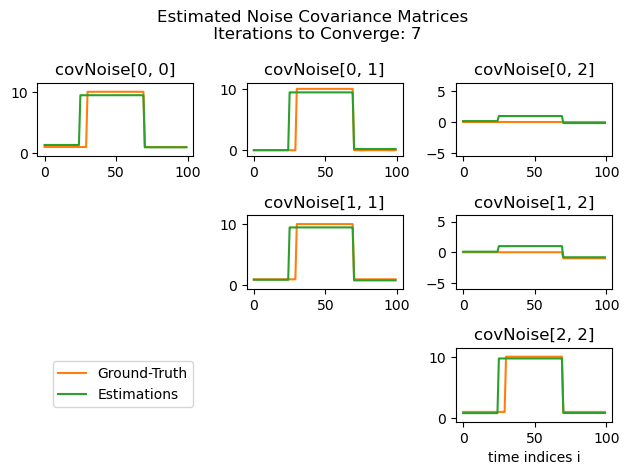

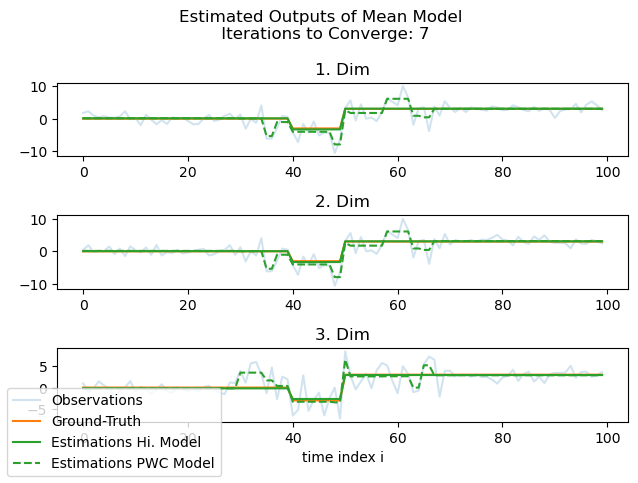

In [13]:
# Specify parameters
beta_u_mean = 5.0   # TODO: Vary sparsifying parameter of mean estimation model (for report, beta_u_mean=5.0 was chosen)
beta_u_cov = 8.0   # TODO: Vary sparsifying parameter of cov. estimation model (for report, beta_u_cov=8.0 was chosen)

# Calculate / construct ingoing messages, needed for PWC model
sigma = np.identity(D, dtype=float)   # Assumed observation noise covariance matricesn for entire estimation
mx_b = y_hi
Vx_b = np.tile(sigma, (N,1,1))

########################################################################################################################

# Initialize estimators
estimator_hi = HiModel(N=N, D=D)
estimator_pwc = PWCModel(N=N, D=D, mode='conventional')

# Do estimation
performanceMetrics, i_it, conv_time = estimator_hi.estimate_output(
    y=y_hi, beta_u_mean=beta_u_mean, beta_u_cov=beta_u_cov, met_convTh_cov=1e-2)
_, _, _ = estimator_pwc.estimate_output(mxix_b=mx_b, VWx_b=Vx_b, beta_u=beta_u_cov)

########################################################################################################################

# Plot covariance matrix estimations
sigmas_hat = estimator_hi.get_sigmasHat()

fig_hiCov, axs_hiCov = plt.subplots(3,3, squeeze=False)

# Delete subplots that are not in upper-triangular
for i in range(3):
    for j in range(i):
        axs_hiCov[i,j].remove()
        
# Calculate window width
min_ij = np.minimum(np.min(sigmas_hat, axis=0), np.min(sigmas, axis=0))
max_ij = np.maximum(np.max(sigmas_hat, axis=0), np.max(sigmas, axis=0))
avg_ij = (max_ij - min_ij) / 2 + min_ij
maxDiff_scaled = np.max(max_ij - min_ij)*1.2

# Iterate through remaining axes
for i in range(3):
    for j in range(i,3):
        axs_hiCov[i,j].plot(sigmas[:,i,j], c='tab:orange')
        axs_hiCov[i,j].plot(sigmas_hat[:,i,j], c='tab:green')
        axs_hiCov[i,j].set_title(f'covNoise[{i}, {j}]')
        
        avg = avg_ij[i,j]
        axs_hiCov[i,j].set_ylim(avg - maxDiff_scaled/2, avg + maxDiff_scaled/2)

axs_hiCov[2,2].set_xlabel('time indices i')

fig_hiCov.suptitle(
    f'Estimated Noise Covariance Matrices \n Iterations to Converge: {i_it + 1}')
fig_hiCov.legend(['Ground-Truth', 'Estimations'], loc='center', bbox_to_anchor=(0.2, 0.2))
fig_hiCov.tight_layout()

# Plot mean estimations
mx_hat, _ = estimator_hi.get_xHat()

fig_hiMean, axs_hiMean = plt.subplots(3, 1, squeeze=False)

# Iterate through all axes
for ax, i in zip(axs_hiMean[:,0], range(3)):
    ax.plot(y_hi[:,i], alpha=0.2)
    ax.plot(x_hi[:,i])
    ax.plot(mx_hat[:,i])
    ax.plot(estimator_pwc.mx_hat[:,i], c='tab:green', linestyle='dashed')
    ax.set_title(f'{i+1}. Dim')

axs_hiMean[2,0].set_xlabel('time index i')

fig_hiMean.suptitle(
    f'Estimated Outputs of Mean Model \n Iterations to Converge: {i_it + 1}')
fig_hiMean.legend(['Observations', 'Ground-Truth', 'Estimations Hi. Model', 'Estimations PWC Model'], loc='lower left')
fig_hiMean.tight_layout()